<a href="https://colab.research.google.com/github/JozeFons/OpenAi_Whisper/blob/main/OpenAi_Whisper_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/openai/whisper.git -q

     |████████████████████████████████| 5.8 MB 32.1 MB/s 
     |████████████████████████████████| 182 kB 75.6 MB/s 
     |████████████████████████████████| 7.6 MB 65.0 MB/s 


In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-124dcd6e-6424-a350-93c1-2639e30eed58)


In [4]:
!pip install pytube -q

     |████████████████████████████████| 57 kB 5.4 MB/s 


Now that we have installed the dependencies, let's import whisper and the YouTube class form pytube.

Whisper transcribes audio speech into text. To see this in action, we'll need some audio to operate on. We'll extract some audio from a YouTube video using the pytube Python package. 

In [5]:
import whisper
from pytube import YouTube

Whisper has a variety of models of varying sizes. The large model will be more accurate but also will be more resource intensive.

In [7]:
model = whisper.load_model('base')

100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 66.2MiB/s]


We will now instatiate a "YouTube object by passing in the video URL. This will allow us to retrieve metadata and stream info about the specified YouTube URL. 

In [8]:
youtube_video_url = "https://www.youtube.com/watch?v=NT2H9iyd-ms" 
youtube_video = YouTube(youtube_video_url)

Now that we have an pytube Youtube object and we is ready to explore some atributes.

In [9]:
youtube_video.title

'WATCH LIVE | Fed Chair Powell Discusses Latest Fed Rate Hike'

In [10]:
youtube_video.streams

[<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="7fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">, <Stream: itag="248" mime_type="video/webm" res="1080p" fps="30fps" vcodec="vp9" progressive="False" type="video">, <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001f" progressive="False" type="video">, <Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">, <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="vid

As you can see, we have a list of video and audio streams of varying quality. We can iterate over this list and observe the difference resolutions and framerates.

In [11]:
for stream in youtube_video.streams:
  print(stream)

<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="7fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">
<Stream: itag="248" mime_type="video/webm" res="1080p" fps="30fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001f" progressive="False" type="video">
<Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">
<St

For this tutorial, we are interested in the audio channel only. Thus, we willl filter down to audio streams only.

In [12]:
streams = youtube_video.streams.filter(only_audio=True)
streams

[<Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">, <Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2" progressive="False" type="audio">, <Stream: itag="249" mime_type="audio/webm" abr="50kbps" acodec="opus" progressive="False" type="audio">, <Stream: itag="250" mime_type="audio/webm" abr="70kbps" acodec="opus" progressive="False" type="audio">, <Stream: itag="251" mime_type="audio/webm" abr="160kbps" acodec="opus" progressive="False" type="audio">]

We don''t need the highest quality audio for this project, so we'll select the first audio stream available. If we want a higher quality transcription, we can select a higher quality audio stream and use a larger Whisper model.

In [13]:
stream = streams.first()
stream

<Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">

Now that we have selected stream we working with, let's download the stream as fed_meeting.mp4. You should see the file appears in the filesystem browser on the side panel of Colab. Click the refresh button if you don't see it after while.

In [14]:
stream.download(filename='fed_meeting.mp4')

'/content/fed_meeting.mp4'

We can do some additional processing on the audio file should we choose. I want to ignore any additional sound and speech after Jerome Powel speaks. So we will use ffmpeg to do this. The command will start the audio file at the 375 second mark where he starts with good aftenoon continue for 2715 seconds and chop off the rest of the audio. The result will be saved in a new file called fed_meeting_trimmed.mp4.

In [17]:
import datetime

# save a timestamp before file trimming
t1 = datetime.datetime.now()
print(f"Trimming started at: {t1}")

!ffmpeg -ss 378 -i fed_meeting.mp4 -t 2715 fed_meeting_trimmed.mp4

# show time elapsed after file trimming is complete.
t2 = datetime.datetime.now()
print(f"Trimming ended at: {t2}")
print(f"Complete time of trimming process: {t2 - t1}")

Trimming started at: 2022-12-20 21:58:55.747256
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

In [18]:
# save a timestamp befor transcription
t3 = datetime.datetime.now()
print(f"Transcription started at: {t3}")

# do the transcription
output = model.transcribe("fed_meeting_trimmed.mp4")

# show time elapsed after transcription is complete.
t4 = datetime.datetime.now()
print(f"Transcription ended at: {t4}")
print(f"Complete time of transcription process: {t4 - t3}")

Transcription started at: 2022-12-20 22:02:02.495176
Transcription ended at: 2022-12-20 22:03:49.087778
Complete time of transcription process: 0:01:46.592602


In [19]:
output

{'text': " Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2% goal. We have both the tools that we need and the resolve it will take to restore price stability on behalf of American families and businesses. Price stability is the responsibility of the Federal Reserve and serves as the bedrock of our economy. Without price stability, the economy does not work for anyone. In particular, without price stability, we will not achieve a sustained period of strong labor market conditions that benefit all. Today, the FOMC raised our policy interest rate by 75 basis points and we continue to anticipate that ongoing increases will be appropriate. We are moving our policy stance purposefully to a level that will be sufficiently restrictive to return inflation to 2%. In addition, we are continuing the process of significantly reducing the size of our balance sheet. Restoring price stability will likely require maintaining a restrictive stance of po

# Merging and Comparing Speech Data with Price Data

Now that we have this speech and the associated timestamps, we can fo further by merging these segments into dataframe containing price data. Let's see how the speech maps to the price of the S&P 500. I have retrieved 5 second OHLCV data for SPY using Interactive Brokers. A copy of this data and the code used to retrieve it are located on the website . We can upload spy.csv to Colab and process it using pandas.

In [20]:
import pandas as pd
from google.colab import files

spy = "https://raw.githubusercontent.com/hackingthemarkets/openai-whisper-live-transcription/main/spy.csv"

spy = pd.read_csv(spy)

spy

,date,open,high,low,close,volume,average,barCount
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130
...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139


Since we have already the segment of the speech and their start and end times in seconds, we can add a new column containing the text that was spoken during each 5 second bar.

In [21]:
for segment in output['segments']:
  second = int(segment['start'])
  second = second - (second % 5)
  spy.loc[second / 5, 'text'] = segment['text']

spy

,date,open,high,low,close,volume,average,barCount,text
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444,Good afternoon. My colleagues and I are stron...
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234,We have both the tools that we need and the r...
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232,NaN
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190,Price stability is the responsibility of the ...
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130,"Without price stability, the economy does not..."
...,...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265,But it's not to the extent we had hoped at th...
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221,NaN
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69,NaN
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139,NaN


Let's also create a new column called 'percent' that stores the percent the price moved duting the 5 second period.

In [22]:
spy['percent'] = ((spy['close'] - spy['open']) / spy['open']) * 100

spy

,date,open,high,low,close,volume,average,barCount,text,percent
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444,Good afternoon. My colleagues and I are stron...,-0.077493
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234,We have both the tools that we need and the r...,0.028438
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232,NaN,-0.077531
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190,Price stability is the responsibility of the ...,0.056900
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130,"Without price stability, the economy does not...",-0.010338
...,...,...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265,But it's not to the extent we had hoped at th...,0.023666
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221,NaN,0.021032
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69,NaN,-0.015771
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139,NaN,-0.005258


We can now filter out dataframe to show bars where the price moved more than a certain percentage. To see where price moved down substantially in a 5 second period, we can filter like is below.

In [23]:
big_down_moves = spy[spy.percent < -0.2]

big_down_moves

,date,open,high,low,close,volume,average,barCount,text,percent
61,2022-11-02 14:36:20,387.74,387.84,386.42,386.45,214600.0,387.037,1225,NaN,-0.332697
62,2022-11-02 14:36:25,386.40,386.44,385.36,385.52,289403.0,385.919,1731,"At some point, as I've said in the last two p...",-0.227743
78,2022-11-02 14:37:45,383.70,383.70,382.90,382.93,152778.0,383.279,805,"To conclude, we understand that our actions a...",-0.200678
93,2022-11-02 14:39:00,383.67,383.69,382.82,382.83,64429.0,383.275,405,How will we know that we've reached that level?,-0.218938
154,2022-11-02 14:44:05,385.86,385.87,385.07,385.08,73029.0,385.440,486,NaN,-0.202146


     |████████████████████████████████| 73 kB 1.8 MB/s 


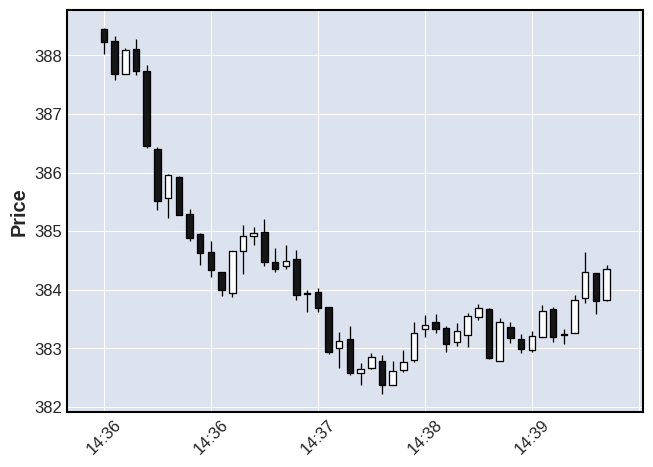

In [24]:
!pip install mplfinance -q
import mplfinance as mpf

df = spy
df.index = pd.DatetimeIndex(df['date'])

mpf.plot(df['2022-11-02 14:36':'2022-11-02 14:39'], type = 'candle')

As we can see the price started to move significantly lower at 14:36 (row 61), so the event "WATCH LIVE | Fed Chair Powell Discusses Latest Fed Rate Hike" affected the price move.

In [25]:
spy[50:70]

,date,open,high,low,close,volume,average,barCount,text,percent
date,,,,,,,,,,
2022-11-02 14:35:25,2022-11-02 14:35:25,386.91,387.24,386.88,387.19,24625.0,387.125,181,NaN,0.072368
2022-11-02 14:35:30,2022-11-02 14:35:30,387.21,387.81,387.20,387.77,97840.0,387.514,688,NaN,0.144624
2022-11-02 14:35:35,2022-11-02 14:35:35,387.73,387.93,387.63,387.65,95192.0,387.808,475,"With today's action, we've raised interest ra...",-0.020633
2022-11-02 14:35:40,2022-11-02 14:35:40,387.64,387.76,387.52,387.55,30898.0,387.617,162,We anticipate that ongoing increases in the t...,-0.023217
2022-11-02 14:35:45,2022-11-02 14:35:45,387.56,388.19,387.56,388.16,148005.0,388.015,823,NaN,0.154815
2022-11-02 14:35:50,2022-11-02 14:35:50,388.15,388.63,388.14,388.22,154486.0,388.446,883,NaN,0.018034
2022-11-02 14:35:55,2022-11-02 14:35:55,388.25,388.46,388.02,388.42,51105.0,388.253,320,Financial conditions have tightened significa...,0.043786
2022-11-02 14:36:00,2022-11-02 14:36:00,388.46,388.47,388.02,388.23,61893.0,388.204,368,NaN,-0.059208
2022-11-02 14:36:05,2022-11-02 14:36:05,388.24,388.34,387.58,387.69,93311.0,387.940,520,"It will take time, however, for the full effe...",-0.141665
